# AI-Powered Ultrasound Image Analysis with Hugging Face


## Object Detection in Medical Imaging - Code-Along Tutorial

## 🎯 Learning Objectives
By the end of this tutorial, you will:

- Learn how to use Hugging Face tools for image analysis
- Understand how to apply hugging face models to ultrasound images
- Explore a real-world use case focused on automatically detecting fetal anatomical structures from ultrasound


## 📋 Prerequisites

- Basic Python programming knowledge
- Familiarity with machine learning concepts
- Understanding of image data (helpful but not required)

# Understanding Medical Image Analysis

## Why Object detection in Medical Imaging Matters

AI is integrated into the healthcare delivery process by assisting clinicians like radiologists to conduct examinations much faster. In a typical medical imaging exam, the radiologist has to manually detect structures present in the image being scanned which ends up being time-consuming, both for the patient and the clinician. AI can reduce this time by automating this detection process and provide real time insights on measurements that can assist in quick and accurate diagnosis. The AI model will learn to automatically locate and classify the structures present in the image.

![](figures/AI_in_radiology_workflow.jpg)


## AI for Low-resource Settings
This is especially important for low-resource settings (LRS). These are contexts where thy lack fundamental aspects like clinical expertise or medical imaging devices necessary to conduct quality healthcare examinations. AI can be used in these settings to empower minimally trained workers to use low-cost devices and provide expert-level care to patients.

## Fetal Ultrasound

Fetal ultrasound is the gold standard for monitoring fetal development and ensuring timely clinical interventions are applied in antenatal care. Variables such as gestational age, fetal growth restriction and maternal risk assessment (pre-eclampsia, placenta previa) are accessed through quality fetal ultrasound scans. This involves detecting key fetal anatomical structures that can tell us how well the baby is developing and if the mother is at risk. These include:

In [ ]:
from pycparser.ply.yacc import token

# Define the structures we will be detecting
# You can download the dataset for this tutorial here: https://drive.google.com/drive/folders/12LkT4P_27BJ56DqUd5Kh7AyEPeTLZohT?usp=sharing

ULTRASOUND_STRUCTURES = {
    'head': {
        'description': 'Fetal head circumference - crucial for gestational age estimation',
        'clinical_importance': 'Growth assessment, brain development monitoring',
        'measurement': 'Head circumference (HC)'
    },
    'abdomen': {
        'description': 'Fetal abdominal circumference - indicates overall growth',
        'clinical_importance': 'Nutritional status, growth restriction detection',
        'measurement': 'Abdominal circumference (AC)'
    },
    'femur': {
        'description': 'Fetal femur length - longest bone measurement',
        'clinical_importance': 'Skeletal development, gestational age estimation',
        'measurement': 'Femur length (FL)'
    },
    'heart': {
        'description': 'Fetal heart structure and function',
        'clinical_importance': 'Cardiac anomaly detection, rhythm assessment',
        'measurement': 'Heart rate, chamber dimensions'
    }
}

# Display structure information
for structure, info in ULTRASOUND_STRUCTURES.items():
    print(f"🫀 {structure.upper()}")
    print(f"   📝 {info['description']}")
    print(f"   🎯 {info['clinical_importance']}")
    print(f"   📏 {info['measurement']}")
    print()

# Introduction to Hugging Face for Computer Vision

Hugging face is a platform that helps users build, deploy and train AI models. The AI community collaborates on sharing pretrained models that users can adapt to their own custom datasets with minimal code. Users have access to cutting-edge research and models, deploy this models with minimal infrastructure and obtain the latest advances in computer vison through continuous updates

## The detection pipeline.

Object detection entails teaching an AI model to identify objects in an image. In this case, the model learns to:
1. Look at the entire image
2. Find regions that might contain objects (spotting interesting areas)
3. Classify what is in each region (naming what they see)
4. Locate precisely where objects are (by drawing bounding boxes around them)

![Object detection pipeline](figures/object-detection-pipeline.jpg)


## [DETR: Hugging Face detection model](https://huggingface.co/facebook/detr-resnet-50)

DETR, short for Detection Transformer, is a deep learning model developed by Facebook AI for object detection tasks. It uses a transformer-based architecture to directly predict object classes and their bounding boxes from an image in an end-to-end fashion. In the Hugging Face Transformers library, DETR models are pre-trained and easy to use for detecting objects in images with just a few lines of code, making it beginner-friendly and powerful for computer vision tasks.

![DETR Architecture](figures/DETR-architecture.jpg)

# Setup Instructions

In [1]:
# Environment setup: Install dependencies
%pip install -q transformers datasets torchvision pycocotools matplotlib scipy

Note: you may need to restart the kernel to use updated packages.


In [2]:
# Imports
import os
import torch
import json
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import warnings
import requests

from datasets import Dataset, DatasetDict
from transformers import DetrImageProcessor, DetrForObjectDetection, Trainer, TrainingArguments

warnings.filterwarnings("ignore")

Phase 1: Load the Dataset

In [3]:
# Define label mappings
id2label = {0: "abdomen", 1: "brain", 2: "femur", 3: "thorax"}
label2id = {v: k for k, v in id2label.items()}
image_processor = DetrImageProcessor.from_pretrained("facebook/detr-resnet-50")

In [4]:
# Helper function to load annotation files
def load_annotations(json_path, image_folder):
    with open(json_path, 'r') as f:
        raw = json.load(f)

    # No groupings needed - each item is already one image with one annotation
    data = []
    labels = []
    for item in raw:
        image_path = os.path.join(image_folder, item["image_filename"])
        data.append({
            "image_path": image_path,
            "bbox": item["bbox"],
            "label": item["label"],
        })
        labels.append(item["label"])
    return data, labels, len(data)


In [5]:
# Transform data
def transform(example):
    image = Image.open(example["image_path"]).convert("RGB")

    # Convert single bbox from Pascal VOC → COCO format
    x_min, y_min, x_max, y_max = example["bbox"]
    bbox_coco = [x_min, y_min, x_max - x_min, y_max - y_min]

    # Process image
    encoding = image_processor(images=image, return_tensors="pt")
    encoding["pixel_values"] = encoding["pixel_values"].squeeze(0)  # Remove batch dimension

    # Single label and bbox (much simpler!)
    encoding["labels"] = [{
        "boxes": torch.tensor([bbox_coco], dtype=torch.float32),  # List with one box
        "class_labels": torch.tensor([label2id[example["label"]]], dtype=torch.int64)  # List with one label
    }]

    return encoding

In [6]:
# Call the helper functions above to load and transform the train and test datasets
train_data, train_labels, len_train = load_annotations("dataset/train_dataset/train_annotations.json", "dataset/train_dataset")

test_data, test_labels, len_test = load_annotations("dataset/test_dataset/test_annotations.json", "dataset/test_dataset")


### Task 2: Inspect the dataset

In [7]:
# Find total number of samples in train and in test.
print(f"Total samples in train: {len_train}")
print(f"Total samples in test: {len_test}")

train_dataset = Dataset.from_list(train_data).map(transform)
test_dataset = Dataset.from_list(test_data).map(transform)

ds = DatasetDict(train=train_dataset, test=test_dataset)


Total samples in train: 40
Total samples in test: 12


Map:   0%|          | 0/40 [00:00<?, ? examples/s]

Map:   0%|          | 0/12 [00:00<?, ? examples/s]

In [8]:
# Visualize classes in the dataset
from collections import Counter
import matplotlib.pyplot as plt

def plot_class_histogram(train_labels, test_labels, train_count, test_count):
    """Plot simple histogram of class distribution"""
    # Count classes
    train_classes = Counter(train_labels)
    test_classes = Counter(test_labels)

    # Create plots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

    # Training histogram
    ax1.bar(train_classes.keys(), train_classes.values(), color='skyblue')
    ax1.set_title(f'Training Set ({train_count} samples)')
    ax1.set_ylabel('Number of Images')

    # Add numbers on bars
    for i, (label, count) in enumerate(train_classes.items()):
        ax1.text(i, count + 0.1, str(count), ha='center', fontweight='bold')

    # Test histogram
    ax2.bar(test_classes.keys(), test_classes.values(), color='lightcoral')
    ax2.set_title(f'Test Set ({test_count} samples)')
    ax2.set_ylabel('Number of Images')

    # Add numbers on bars
    for i, (label, count) in enumerate(test_classes.items()):
        ax2.text(i, count + 0.05, str(count), ha='center', fontweight='bold')

    plt.tight_layout()
    plt.show()

    return train_classes, test_classes

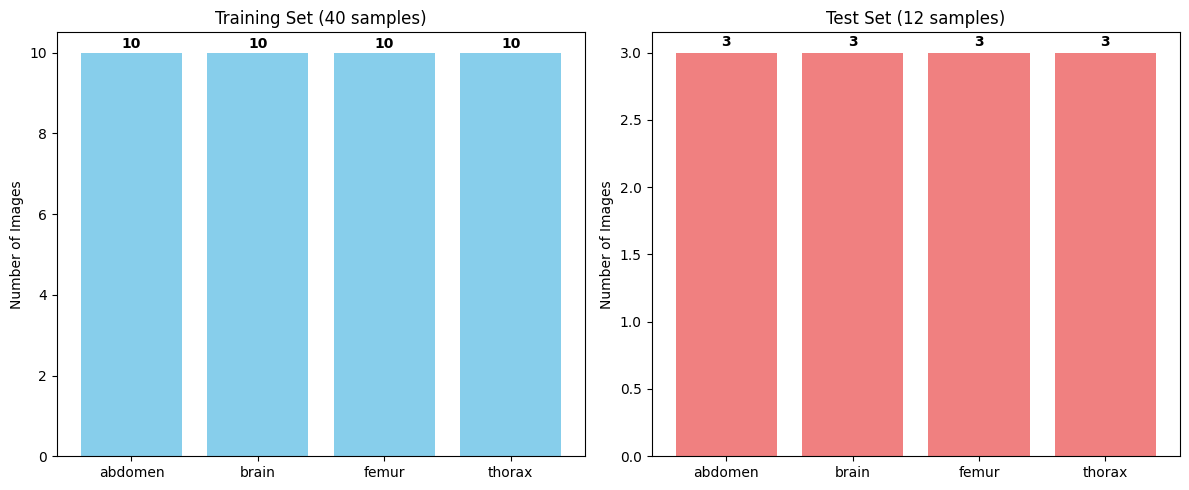

(Counter({'abdomen': 10, 'brain': 10, 'femur': 10, 'thorax': 10}),
 Counter({'abdomen': 3, 'brain': 3, 'femur': 3, 'thorax': 3}))

In [9]:
# Call helper function to visualize class distribution
plot_class_histogram(train_labels, test_labels, len_train, len_test)

In [9]:
# Helper function to load the image
def visualize_image(image_path, annotations):
    """
    Visualize one image with its bounding box from JSON annotations

    Args:
        image_path: Path to the image file
        json_file: Path to the JSON annotation file
    """

    # Get image filename from path
    image_filename = image_path.split('/')[-1]

    # Find annotation for this image from the annotations file
    annotation = None
    for ann in annotations:
        if ann['image_filename'] == image_filename:
            annotation = ann
            break

    if annotation is None:
        print(f"No annotation found for {image_filename}")
        return

    # Load and display image
    image = Image.open(image_path)

    fig, ax = plt.subplots(1,figsize=(8, 5))
    ax.imshow(image, cmap='gray')

    # Get bbox and label
    bbox = annotation['bbox']  # [x_min, y_min, x_max, y_max]
    label = annotation['label']

    # Calculate width and height
    x_min, y_min, x_max, y_max = bbox
    width = x_max - x_min
    height = y_max - y_min

    # Draw bounding box
    rect = patches.Rectangle(
        (x_min, y_min), width, height,
        linewidth=3, edgecolor='green', facecolor='none'
    )
    ax.add_patch(rect)

    # Add label text
    ax.text(x_min, y_min-5, label,
            bbox=dict(boxstyle="round", facecolor='green', alpha=0.7),
            fontsize=12, color='white', weight='bold')

    ax.set_title(f'{image_filename} - {label}')
    ax.axis('off')
    # plt.show()


    # Remove axis ticks and labels
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(f'Image: {image_path.split("/")[-1]}', fontsize=14, fontweight='bold')

    plt.tight_layout()
    plt.axis('off')
    plt.show()

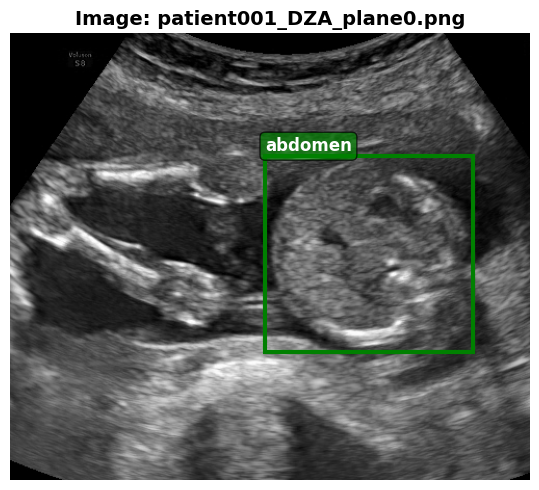

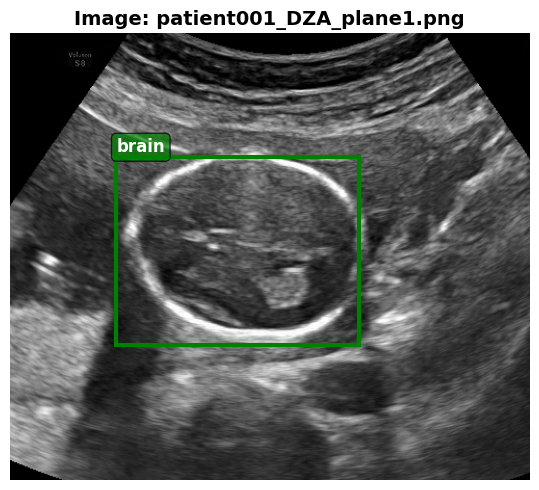

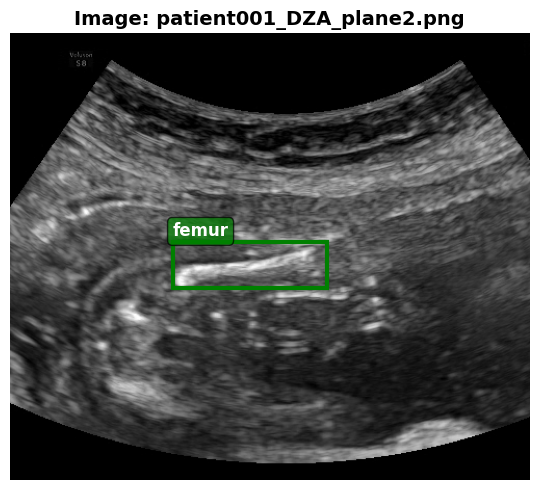

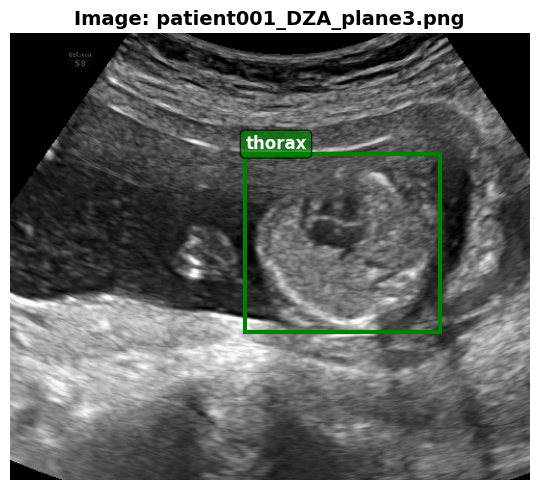

In [10]:
# Visualize ultrasound image with annotations for all classes
with open("dataset/train_dataset/train_annotations.json", "r") as f:
    annotations = json.load(f)

# Abodomen
visualize_image("dataset/train_dataset/patient001_DZA_plane0.png", annotations)

# Brain
visualize_image("dataset/train_dataset/patient001_DZA_plane1.png", annotations)

# Femur
visualize_image("dataset/train_dataset/patient001_DZA_plane2.png", annotations)

# Thorax
visualize_image("dataset/train_dataset/patient001_DZA_plane3.png", annotations)

### Task 2: Load the pretrained detector model

In [11]:
# Download model from hugging face libray
model = DetrForObjectDetection.from_pretrained(
    "facebook/detr-resnet-50",
    num_labels=len(id2label),
    label2id=label2id,
    ignore_mismatched_sizes=True
)

Some weights of the model checkpoint at facebook/detr-resnet-50 were not used when initializing DetrForObjectDetection: ['model.backbone.conv_encoder.model.layer1.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer2.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer3.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer4.0.downsample.1.num_batches_tracked']
- This IS expected if you are initializing DetrForObjectDetection from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DetrForObjectDetection from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DetrForObjectDetection were not initialized from the model checkpoin

### Task 4: Define evaluation metrics

In [13]:
# Define evaluation metrics
def box_iou(boxA, boxB):
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[0] + boxA[2], boxB[0] + boxB[2])
    yB = min(boxA[1] + boxA[3], boxB[1] + boxB[3])

    interArea = max(0, xB - xA) * max(0, yB - yA)
    boxAArea = boxA[2] * boxA[3]
    boxBArea = boxB[2] * boxB[3]
    iou = interArea / float(boxAArea + boxBArea - interArea + 1e-6)
    return iou


def compute_metrics(eval_preds):
    preds, targets = eval_preds
    results = []

    for pred, target in zip(preds["pred_boxes"], preds["labels"]):
        pred_boxes = pred["boxes"]
        pred_labels = pred["labels"]
        gt_boxes = target["boxes"]
        gt_labels = target["labels"]

        correct = 0
        for gt_box, gt_label in zip(gt_boxes, gt_labels):
            for p_box, p_label in zip(pred_boxes, pred_labels):
                if p_label == gt_label:
                    if box_iou(gt_box, p_box) > 0.5:
                        correct += 1
                        break
        precision = correct / len(gt_boxes) if gt_boxes else 0
        results.append(precision)
    return {"mean_precision@IoU>0.5": np.mean(results)}

### Task 5: Set model training parameters

In [14]:
#  Function to combin multiple data samples into a single batch during training
def collate_fn(batch):
    # Stack pixel values (convert lists to tensors if needed)
    pixel_values = torch.stack([
        torch.tensor(x["pixel_values"], dtype=torch.float32) if isinstance(x["pixel_values"], list)
        else x["pixel_values"]
        for x in batch
    ])

    # Extract labels and ensure they're tensors
    labels = []
    for x in batch:
        label_dict = x["labels"][0]
        labels.append({
            "boxes": torch.tensor(label_dict["boxes"], dtype=torch.float32) if isinstance(label_dict["boxes"], list) else label_dict["boxes"],
            "class_labels": torch.tensor(label_dict["class_labels"], dtype=torch.int64) if isinstance(label_dict["class_labels"], list) else label_dict["class_labels"]
        })

    return {"pixel_values": pixel_values, "labels": labels}

In [15]:
from torch.utils.data import DataLoader
from transformers import Trainer, TrainingArguments

# Setup trainer for finetuning

training_args = TrainingArguments(
    output_dir="./detr-ultrasound",
    per_device_train_batch_size=8,
    learning_rate=1e-5,
    num_train_epochs=5,
    save_steps=50,
    logging_steps=5,
    eval_strategy="no",
    save_total_limit=1,
    remove_unused_columns=False,
    fp16=torch.cuda.is_available(),
    seed=4,
    warmup_steps=10,
    report_to="none",
)


trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=ds["train"],
    eval_dataset=ds["test"],
    tokenizer=image_processor,
    compute_metrics=compute_metrics,
    data_collator=collate_fn,
)


### Task 6: Fine-tune the model (training)

In [16]:
# Call the trainer function
trainer.train()

Step,Training Loss
5,3249.960900
10,3249.862300
15,3249.635000
20,3249.451800
25,3249.352000


TrainOutput(global_step=25, training_loss=3249.6523828125, metrics={'train_runtime': 502.2522, 'train_samples_per_second': 0.398, 'train_steps_per_second': 0.05, 'total_flos': 1.110914852256e+17, 'train_loss': 3249.6523828125, 'epoch': 5.0})

### Task 7: Assess the fine-tuned model

In [26]:
# Visualize prediction vs ground truth

# Load the fine-tuned model we  just trained
trained_model = DetrForObjectDetection.from_pretrained("detr-ultrasound/checkpoint-25")
trained_processor = DetrImageProcessor.from_pretrained("detr-ultrasound/checkpoint-25")

In [35]:
# Helper function to visualize model prediction

def visualize_prediction(image_path, gt_box, gt_label, trained_processor, trained_model):
    image = Image.open(image_path).convert("RGB")
    inputs = trained_processor(images=image, return_tensors="pt")
    outputs = trained_model(**inputs)

    target_sizes = torch.tensor([image.size[::-1]])
    results = image_processor.post_process_object_detection(outputs, target_sizes=target_sizes, threshold=0.42)[0] # threshold should be as high as possible to get the most confident output
    print("results:", results)
    fig, ax = plt.subplots(1, 1, figsize=(8, 8))
    ax.imshow(image)

    # Ground truth (single box and label)
    x_min, y_min, x_max, y_max = gt_box  # Pascal VOC format
    w, h = x_max - x_min, y_max - y_min
    rect = patches.Rectangle((x_min, y_min), w, h, linewidth=2, edgecolor='g', facecolor='none')
    ax.add_patch(rect)
    ax.text(x_min, y_min-5, f'GT: {gt_label}', color='green', fontsize=9)
    print("GT: box:", gt_box, "label:", gt_label)

    # Predictions
    for box, label, score in zip(results["boxes"], results["labels"], results["scores"]):
        print(f"Predicted: box: {box}, label: {id2label[label.item()]}, score: {score.item():.2f}")
        x1, y1, x2, y2 = box.tolist()  # DETR outputs are in x1,y1,x2,y2 format
        w, h = x2 - x1, y2 - y1
        rect = patches.Rectangle((x1, y1), w, h, linewidth=2, edgecolor='r', facecolor='none')
        ax.add_patch(rect)
        ax.text(x1, y1+h+5, f'Pred: {id2label[label.item()]} ({score:.2f})', color='red', fontsize=9)

    plt.axis('off')
    plt.show()



results: {'scores': tensor([], grad_fn=<IndexBackward0>), 'labels': tensor([], dtype=torch.int64), 'boxes': tensor([], size=(0, 4), grad_fn=<IndexBackward0>)}
GT: box: [99, 125, 367, 190] label: femur


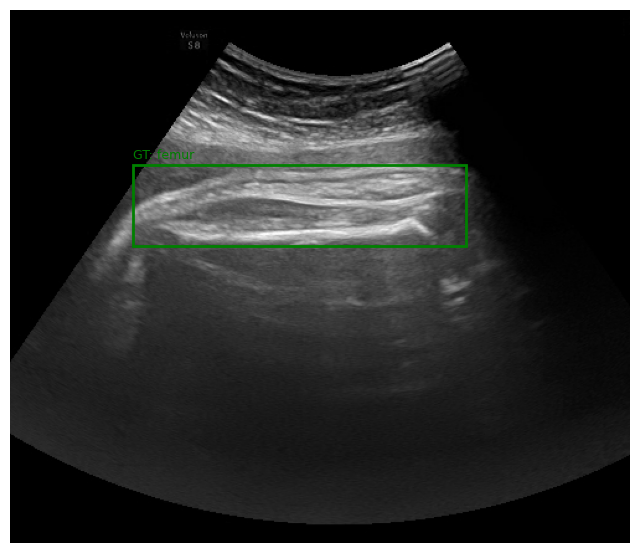

In [37]:
# Run on one test sample to assess prediction
sample = ds["test"][2]
visualize_prediction(sample["image_path"], sample["bbox"], sample["label"], trained_processor, trained_model)